In [ ]:
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

es_problem = ElectronicStructureProblem(driver)
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)

from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

numpy_solver = NumPyMinimumEigensolver()
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem) 
print(res)

In [124]:
from qiskit import QuantumCircuit,QuantumRegister
def eH_H2(nim_qubits,alpha=1):
    qc = QuantumCircuit(2)
    qc.rxx(0.18093119978423114*alpha,1,0)
    qc.rz(-0.39793742484317884*alpha,1)
    qc.rz(0.39793742484317884*alpha,0)
    qc.rzz(-0.011280104256235171*alpha,1,0)
    return qc

def eH_mixer(num_qubits,beta=1):
    qc = QuantumCircuit(2)
    qc.rx(beta,0)
    qc.rx(beta,1)
    return qc

def initial_sate(num_qubits):
    qc = QuantumCircuit(num_qubits)
    [qc.h(i) for i in range(num_qubits)]
    #[qc.s(i) for i in range(num_qubits)]
    return qc

In [19]:
def QAOA(n_qubtis,initial_state,mixer,cost,parameters,N):
    q_register = QuantumRegister(n_qubtis,'q')
    qc = QuantumCircuit(q_register,name='QAOA')
    qc = qc.compose(initial_state(n_qubtis),q_register)
    for p in range(N):
        alpha,beta = parameters[2*p],parameters[p+1]
        qc = qc.compose(cost(n_qubtis,alpha),q_register)
        qc = qc.compose(mixer(n_qubtis,beta),q_register)

    return qc

In [20]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

def execute_circuit(qc, shots=1024, device=None):
    device = Aer.get_backend('qasm_simulator') if device is None else device
    transpiled_circuit = transpile(qc, device)
    counts = device.run(transpiled_circuit, shots=shots).result().get_counts()
    return counts

def basis_states_probs(counts):
    n = len(list(counts.keys())[0])
    N = sum(list(counts.values()))
    return np.array([counts[np.binary_repr(vals,n)]/N if counts.get(np.binary_repr(vals,n)) is not None else 0 for vals in range(2**n)])

In [21]:
import re

def get_H(s):
    f = lambda a: (float(a[0]),a[1])
    return list(map(f,re.findall(r'([+-]?[^*]+)\*(\w+)',re.sub(r'[ \t\n]+','',s))))

In [125]:
def H_H2(params=None, N=1, shots=2048):
    H = '''0.18093119978423114 * XX
        - 1.0523732457728605 * II
        - 0.39793742484317884 * ZI
        + 0.39793742484317884 * IZ
        - 0.011280104256235171 * ZZ'''

    expval = 0
    for c,h in get_H(H):
        quantum_register = QuantumRegister(2)
        qc = QuantumCircuit(quantum_register)
        qc = qc.compose(QAOA(2,initial_sate,eH_mixer,eH_H2,params,N),quantum_register)
        eig_vals = np.ones(4)
        for i,p in enumerate(h[::-1]):
            if p == 'X':
                qc.h(i)
            if p != 'I':
                eig_vals *= np.array([(-1)**int(np.binary_repr(n,2)[::-1][i]) for n in range(4)])
        qc.measure_all()
        expval += c*np.sum(basis_states_probs(execute_circuit(qc,shots=shots))*eig_vals)
    
    return expval
        


In [139]:
def get_basis_change(p):
    qc = QuantumCircuit(1)
    if p == 'X':
            qc.h(0)
    if p == 'Y':
        qc.u(np.pi/2,np.pi/2,np.pi/2,0)
    return qc

def get_rGate(n_qubits,h):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register)
    contrl_index = [i for i,c in enumerate(h[::-1]) if c != 'I']
    if len(contrl_index) == 0:
        return qc,-1
    for i in contrl_index:
        qc = qc.compose(get_basis_change(h[::-1][i]),[i])
    for i,k in enumerate(contrl_index[::-1][:-1]):
        qc.cx(k,contrl_index[::-1][i+1])
    return qc,contrl_index[0]

def compute_eh(n_qubits,c,h,alpha):
    q_register = QuantumRegister(n_qubits)
    qc = QuantumCircuit(q_register)
    rGate,qr = get_rGate(n_qubits,h)
    if qr == -1:
        return qc
    qc = qc.compose(rGate,range(n_qubits))
    qc.rz(c*alpha,qr)
    qc = qc.compose(rGate.inverse(),range(n_qubits))
    return qc


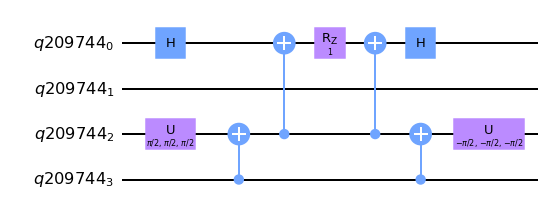

In [146]:
compute_eh(4,1,'ZYIX',1).draw(output='mpl')

In [95]:
def get_EvolutionOperator(H):
    Hamiltonian = get_H(H)
    def get_eH(num_qubits,alpha):
        num_qubits = len(Hamiltonian[0][1])
        qregister = QuantumRegister(num_qubits)
        qc = QuantumCircuit(qregister)
        for c,h in Hamiltonian:
            qc = qc.compose(compute_eh(num_qubits,c,h,alpha),range(num_qubits))
        return qc
    return get_eH

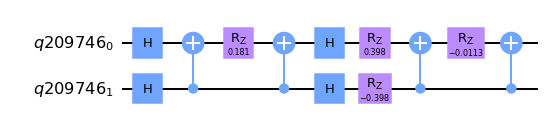

In [147]:
H = '''0.18093119978423114 * XX
        - 1.0523732457728605 * II
        - 0.39793742484317884 * ZI
        + 0.39793742484317884 * IZ
        - 0.011280104256235171 * ZZ'''
get_EvolutionOperator(H)(2,1).draw(output='mpl')

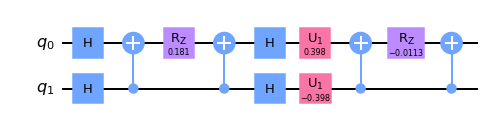

In [126]:
eH_H2(2,1).decompose().draw(output='mpl')

In [85]:
def H_H2_new(state_preparation, shots=2048):
    H = '''0.18093119978423114 * XX
        - 1.0523732457728605 * II
        - 0.39793742484317884 * ZI
        + 0.39793742484317884 * IZ
        - 0.011280104256235171 * ZZ'''

    expval = 0
    for c,h in get_H(H):
        quantum_register = QuantumRegister(2)
        qc = QuantumCircuit(quantum_register)
        qc = qc.compose(state_preparation,quantum_register)
        eig_vals = np.ones(4)
        for i,p in enumerate(h[::-1]):
            if p != 'Z' and p != 'I':
                qc = qc.compose(get_basis_change(p),[i])
            if p != 'I':
                eig_vals *= np.array([(-1)**int(np.binary_repr(n,2)[::-1][i]) for n in range(4)])
        qc.measure_all()
        expval += c*np.sum(basis_states_probs(execute_circuit(qc,shots=shots))*eig_vals)
    
    return expval

In [154]:
from qiskit.algorithms.optimizers import COBYLA

N=6
params = np.random.random(2*N)*2*np.pi
optimizer = COBYLA()

objective_function = lambda pp: H_H2_new(params=pp,N=N)

opt_var, opt_value, _ = optimizer.optimize(2*N, objective_function, initial_point=params)

opt_var,opt_value

(array([5.98733865, 2.02998955, 4.79314889, 1.30102581, 1.00258629,
        4.72005547, 3.95730622, 2.23502542, 0.72611663, 4.37472867,
        3.84391814, 5.88991382]),
 -1.8461629428684045)

In [77]:
import optuna

def objective(trial):
    params = [trial.suggest_float(f"alpha_{n}" if n%2==0 else f"beta_{n}", -2*np.pi, 2*np.pi) for n in range(2*N)]
    return H_H2(params,N)
    
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(multivariate=True),
)

study.optimize(objective, 500, 60*10)

c:\Users\reasc\miniconda3\lib\site-packages\optuna\samplers\_tpe\sampler.py:263: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2022-05-13 12:09:36,153] A new study created in memory with name: no-name-70ee50c1-922f-49a1-9473-9409b5c04042
[I 2022-05-13 12:09:37,630] Trial 0 finished with value: -1.2058512818400788 and parameters: {'alpha_0': 1.6137797065889146, 'beta_1': 1.1923912229905183, 'alpha_2': -2.8786631480908134, 'beta_3': 3.5987259605078172, 'alpha_4': 3.1962281081227015, 'beta_5': -5.37876640392335, 'alpha_6': -0.5327653510943033, 'beta_7': -3.9078032580872395, 'alpha_8': 4.17522833507725, 'beta_9': 0.1475269244266295, 'alpha_10': 4.593774117584447, 'beta_11': -5.542543821325054, 'alpha_12': -0.16995778957844987, 'beta_13': 4.747876718293057, 'alpha_14': 0.09712983694437938, 'beta_15': -2.2076552393041657, 'alpha_16': 0.36067319640690876, 'beta_17': 2.055689004437051, 'alpha_18': 4.04174839

In [78]:
optuna_params= {'alpha_0': -0.3034293739468007, 'beta_1': -6.018081851235714, 'alpha_2': -3.9230602811143767, 'beta_3': -1.6111331188160543, 'alpha_4': -5.080594594017833, 'beta_5': 0.5052364968438157, 'alpha_6': -2.588458347545745, 'beta_7': -3.0488185918663104, 'alpha_8': 1.634929536845242, 'beta_9': 5.224851797993304}
H_H2(list(optuna_params.values()),N=N,shots=2**14)

IndexError: list index out of range